In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
# %% [code]
# 데이터 경로 설정
scene_folder = "/home/knuvi/Desktop/song/Pointcept/data/merge_3dgs-attr_pdis0001_opacity-scale-rotation-agg-mean/val/scene0011_00"  # scene 폴더 경로
feature_path = os.path.join(scene_folder, "features.npy")

# feature.npy 파일 로드
if not os.path.exists(feature_path):
    raise FileNotFoundError(f"{feature_path} 파일이 존재하지 않습니다. 경로를 확인해주세요.")
features = np.load(feature_path)

# 데이터 차원 확인
print("Feature shape:", features.shape)

# 속성 분리 (가정: scale=[0:3], opacity=[3:4], rotation=[4:7])
scale = features[:, 0:3]  # [N, 3]
opacity = features[:, 3:4]  # [N, 1]
rotation = features[:, 4:7]  # [N, 3]

print("Scale shape:", scale.shape)
print("Opacity shape:", opacity.shape)
print("Rotation shape:", rotation.shape)

Feature shape: (237360, 7)
Scale shape: (237360, 3)
Opacity shape: (237360, 1)
Rotation shape: (237360, 3)



Scale 통계:
최소값: 0.0000
최대값: 0.1614
평균: 0.0160
표준편차: 0.0098
NaN 값 개수: 0
Inf 값 개수: 0


/home/knuvi/miniconda3/envs/pt/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/knuvi/miniconda3/envs/pt/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/knuvi/miniconda3/envs/pt/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/knuvi/miniconda3/envs/pt/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/knuvi/miniconda3/envs/pt/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from cu

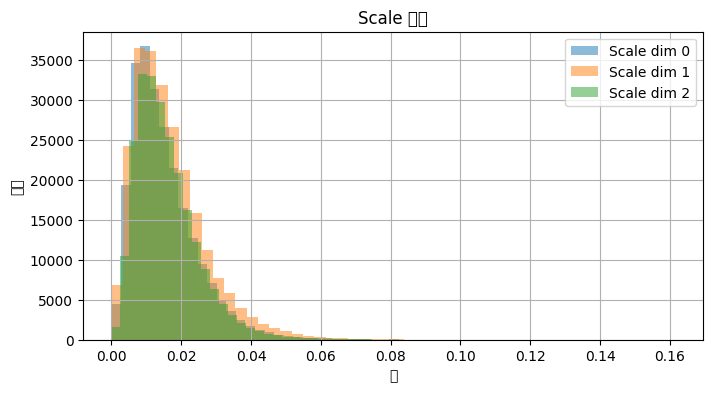


Opacity 통계:
최소값: 0.0040
최대값: 0.9896
평균: 0.2533
표준편차: 0.1850
NaN 값 개수: 0
Inf 값 개수: 0


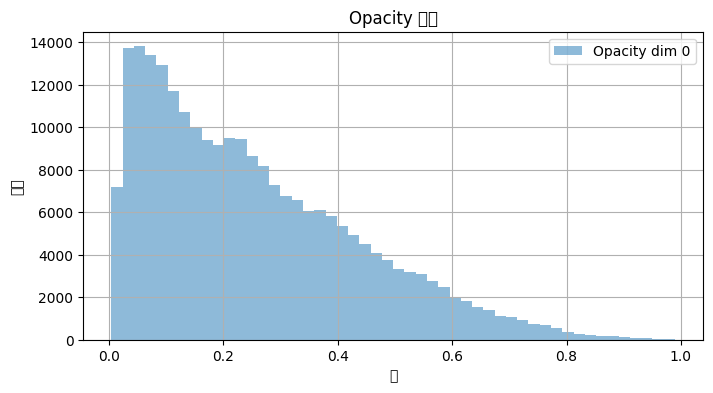


Rotation 통계:
최소값: -0.9774
최대값: 0.9998
평균: 0.3049
표준편차: 0.4548
NaN 값 개수: 0
Inf 값 개수: 0


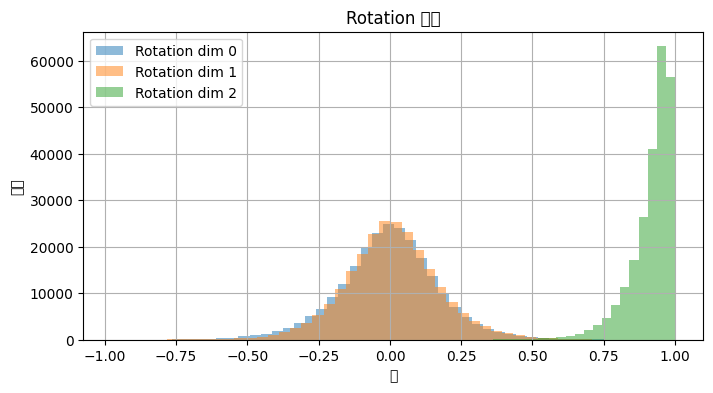

In [3]:
# %% [code]
# 통계 정보 출력 함수
def print_stats(data, name):
    print(f"\n{name} 통계:")
    print(f"최소값: {np.min(data):.4f}")
    print(f"최대값: {np.max(data):.4f}")
    print(f"평균: {np.mean(data):.4f}")
    print(f"표준편차: {np.std(data):.4f}")
    print(f"NaN 값 개수: {np.isnan(data).sum()}")
    print(f"Inf 값 개수: {np.isinf(data).sum()}")

# 히스토그램 시각화 함수
def plot_histogram(data, name, bins=50):
    plt.figure(figsize=(8, 4))
    if data.ndim == 2:
        # 다차원 데이터의 경우 각 차원별로 히스토그램을 그림
        for i in range(data.shape[1]):
            plt.hist(data[:, i], bins=bins, alpha=0.5, label=f"{name} dim {i}")
    else:
        plt.hist(data, bins=bins, alpha=0.5, label=name)
    plt.title(f"{name} 분포")
    plt.xlabel("값")
    plt.ylabel("빈도")
    plt.legend()
    plt.grid(True)
    plt.show()

# Scale 분석
print_stats(scale, "Scale")
plot_histogram(scale, "Scale")

# Opacity 분석
print_stats(opacity, "Opacity")
plot_histogram(opacity, "Opacity")

# Rotation 분석
print_stats(rotation, "Rotation")
plot_histogram(rotation, "Rotation")

In [9]:
# 전처리 함수 정의
def preprocess_features(scale, opacity, rotation):
    # Scale 전처리
    # 1. NaN, Inf 처리 (0으로 대체)
    scale = np.nan_to_num(scale, nan=0.0, posinf=0.0, neginf=0.0)
    # 2. 양수 보장 (작은 값 추가)
    scale = np.maximum(scale, 1e-6)
    # 3. 로그 변환
    scale_log = np.log(scale)
    # 4. Min-Max 정규화
    scale_min = np.min(scale_log)
    scale_max = np.max(scale_log)
    if scale_max != scale_min:  # 분모가 0이 되는 경우 방지
        scale_normalized = (scale_log - scale_min) / (scale_max - scale_min)
    else:
        scale_normalized = np.zeros_like(scale_log)

    # Opacity 전처리
    # 1. NaN, Inf 처리 (0으로 대체)
    opacity = np.nan_to_num(opacity, nan=0.0, posinf=0.0, neginf=0.0)
    # 2. [0, 1]로 클리핑
    opacity_clipped = np.clip(opacity, 0.0, 1.0)

    # Rotation 전처리
    # 1. NaN, Inf 처리 (0으로 대체)
    rotation = np.nan_to_num(rotation, nan=0.0, posinf=0.0, neginf=0.0)
    # 2. [-1, 1]로 정규화 (방향 벡터 가정)
    rotation_norm = np.linalg.norm(rotation, axis=1, keepdims=True)
    rotation_normalized = np.where(rotation_norm > 0, rotation / rotation_norm, rotation)
    rotation_normalized = np.clip(rotation_normalized, -1.0, 1.0)

    return scale_normalized, opacity_clipped, rotation_normalized

# 전처리 적용
scale_processed, opacity_processed, rotation_processed = preprocess_features(scale, opacity, rotation)

# 전처리 후 데이터 결합
features_processed = np.concatenate([scale_processed, opacity_processed, rotation_processed], axis=1)
print("Processed features shape:", features_processed.shape)

Processed features shape: (237360, 7)



Scale (Processed) 통계:
최소값: 0.0000
최대값: 0.0000
평균: 0.0000
표준편차: 0.0000
NaN 값 개수: 0
Inf 값 개수: 0


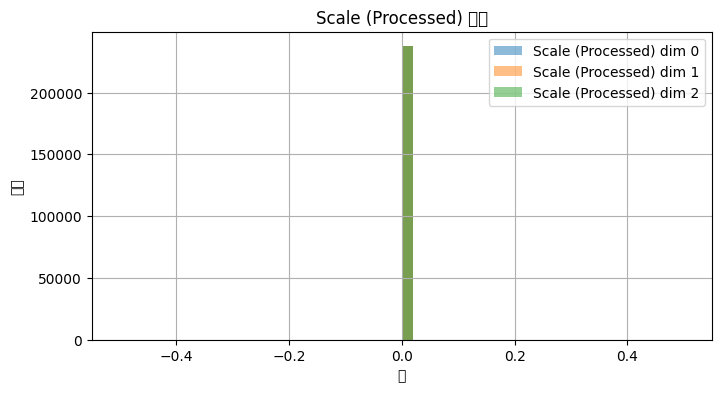


Opacity (Processed) 통계:
최소값: 0.0000
최대값: 1.0000
평균: 0.0658
표준편차: 0.2174
NaN 값 개수: 0
Inf 값 개수: 0


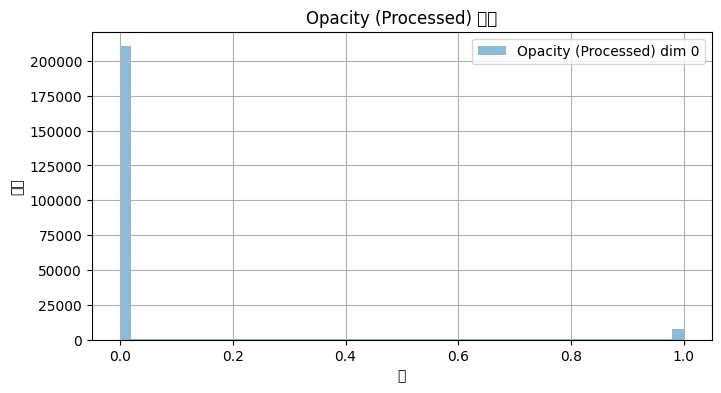


Rotation (Processed) 통계:
최소값: -0.9998
최대값: 1.0000
평균: 0.3260
표준편차: 0.4765
NaN 값 개수: 0
Inf 값 개수: 0


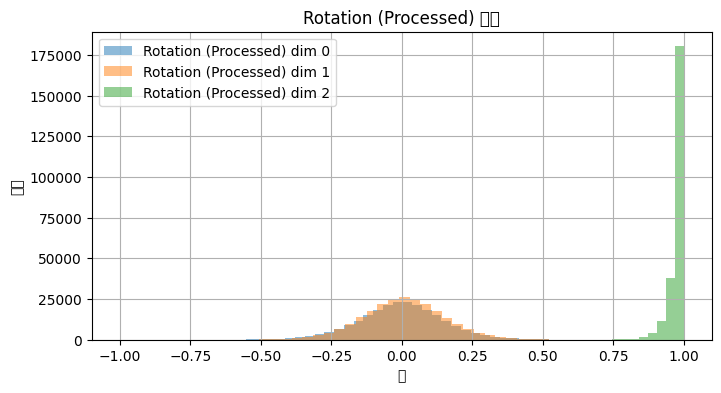

In [10]:
# %% [code]
# Scale 전처리 후 분석
print_stats(scale_processed, "Scale (Processed)")
plot_histogram(scale_processed, "Scale (Processed)")

# Opacity 전처리 후 분석
print_stats(opacity_processed, "Opacity (Processed)")
plot_histogram(opacity_processed, "Opacity (Processed)")

# Rotation 전처리 후 분석
print_stats(rotation_processed, "Rotation (Processed)")
plot_histogram(rotation_processed, "Rotation (Processed)")